# RandomForest 隨機森林
```
1. 敘述性理解: 以決策樹維基礎, 會以取後放回的抽樣方式(boots sample)去訓練每一棵決策樹, 根據每棵樹分類的結果去投票, 做最後的分類結果
2. OOB error(out-of-bag error), 因為會做boots sample, 每棵樹的訓練資料是subset of train data, 沒被抽到的資料就是out-of-bag, 利用oob資料給決策樹做決策, 一樣投票後算出猜錯機率(錯誤個數/訓練資料個數), 可以用oob error來過濾feature values, 有點像feature selection, 不過, 這個地方是黑盒子, 你不知道fit的時候他隨機抽了什麼樣本, 這樣的feature select我想應該難令人放心..., 以分詞來講, 我想還是用entropy機制來去除贅詞會比較好
3. 參考資料: https://read01.com/mEjD8O.html
            
```

In [1]:
%reset -f
%pylab inline
import sys, codecs, pandas as pd, numpy as np, os, re, traceback, pprint, sqlite3, importlib
import jieba, jieba.analyse
from __future__ import division, unicode_literals, with_statement, print_function
from sklearn import datasets
from contextlib import closing

rootPath = 'D:/Gary/WinPython/WinPython-64bit-2.7.10.3/notebooks'

class DataSources(object):    
    def sklearnDs(self):
        return sqlite3.connect(rootPath + '/sklearnDs.sqlite')

    def t1nscp(self):
        oraClient = 'D:/Gary/instantclient_11_1_x64'
        nlsLang = 'AMERICAN_AMERICA.UTF8'
        oracle = loader.loadOracle(oraClient, nlsLang)
        conf = pd.Series(dict(
            user='basman',
            password='MANUser0617',
            host='172.16.32.196',
            port='7540',
            sid='T1NSCP'
        ))
        return oracle.connect(conf.user, conf.password, oracle.makedsn(conf.host, conf.port, conf.sid))

ds = DataSources()

Populating the interactive namespace from numpy and matplotlib


In [2]:
# 抓出頻果新聞資料
apple36Df, apple78Df = None, None
with closing(ds.sklearnDs()) as sklearnConn:
    apple78Df = pd.read_sql('''
        select forum, subject, term, keyword, content, pageurl
          from tb_apple_20160701_20160823_02
         order by batchno
    ''', sklearnConn)
    
    apple36Df = pd.read_sql('''
        select forum, subject, term, keyword, content, pageurl
          from tb_apple_20160301_20160630_02
         order by batchno
    ''', sklearnConn)
apple36Df.head()

,forum,subject,term,keyword,content,pageurl
0,strange,農婦打噴嚏燒傷8頭驢 20萬飛了,山東 劉姓 農婦 打火機 編號 掛牌 噴嚏 倒楣 驢子 燒傷 人民幣 台幣 中國 齊魯 報導...,驢子 驢子 驢子 驢子 驢子 驢子 驢子 農婦 農婦 農婦 農婦 噴嚏 噴嚏 噴嚏 紋身 紋...,山東一名劉姓農婦，日前在用打火機替家中飼養的毛驢掛上編號掛牌時，忍不住打了個噴嚏，沒想到手一...,http://www.appledaily.com.tw/realtimenews/arti...
1,strange,最新款007座駕 日內瓦展前曝光,形象 英國 martin 旗下 十二 跑車 消息 國外 媒體 瑞士 時間 日內瓦 車展 推出...,車展 車展 新款 新款 優雅 優雅 力表 過動 渦輪引擎 曝光 曝光 渦輪 元則 端倪 ma...,形象與007專屬座駕密不可分的英國Aston Martin，旗下行之有年的DB9十二缸跑車，...,http://www.appledaily.com.tw/realtimenews/arti...
2,strange,上班族好無奈 最怕同事這些壞習慣,職場 同事 百款 上班族 星期 同事 時間 小時 小心 衛生習慣 公德心 習慣 同事 報導 ...,冰箱 冰箱 冰箱 同事 同事 同事 生氣 生氣 衛生習慣 百款 大吼大叫 易怒 公德心 公用...,職場同事百百款，身為一位上班族，一星期有5天必須跟同事見面，每天相處時間還得要8小時以上，如...,http://www.appledaily.com.tw/realtimenews/arti...
3,strange,【占卜】你為什麼想分手？,單身 相愛 分手 原因 家庭 壓力 第三者 金錢 工作 老師 數字 占卜 分手 原因 楊婷 ...,分手 分手 分手 分手 愛情 愛情 愛情 相愛 相愛 資料 資料 資料 資料 照片 照片 照...,你恢復單身了嗎？相愛容易相處難，會讓你想分手的原因是什麼呢？是家庭壓力、第三者、金錢還是工作...,http://www.appledaily.com.tw/realtimenews/arti...
4,strange,【旅途中】櫻花叢中的小精靈,櫻花 季節 發現 櫻花 雙活 眼睛 棲蘭 武陵農場 意外 漂亮 實在 可愛 小精靈 棲蘭 國...,棲蘭 棲蘭 櫻花 櫻花 櫻花 畫眉 畫眉 武陵農場 武陵農場 賞櫻 賞櫻 親子 親子 雙活 ...,春暖花開，又到了追櫻花的季節，有沒有發現粉嫩粉嫩的櫻花，幾雙活靈活現的的眼睛在盯著呢？愛玩姐...,http://www.appledaily.com.tw/realtimenews/arti...


In [3]:
from sklearn.ensemble import RandomForestClassifier
help(RandomForestClassifier)

Help on class RandomForestClassifier in module sklearn.ensemble.forest:

class RandomForestClassifier(ForestClassifier)
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and use averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  The sub-sample size is always the same as the original
 |  input sample size but the samples are drawn with replacement if
 |  `bootstrap=True` (default).
 |  
 |  Read more in the :ref:`User Guide <forest>`.
 |  
 |  Parameters
 |  ----------
 |  n_estimators : integer, optional (default=10)
 |      The number of trees in the forest.
 |  
 |  criterion : string, optional (default="gini")
 |      The function to measure the quality of a split. Supported criteria are
 |      "gini" for the Gini impurity and "entropy" for the information gain.
 |      Note: this parameter is tree-specific.
 |  
 |  max_features : int, fl

In [5]:
# 看預測的結果似乎沒有 SGDClassifier 好, 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

rfc = RandomForestClassifier(criterion='entropy', n_jobs=2, oob_score=True)
vec = TfidfVectorizer()
trainMx = vec.fit_transform(apple36Df.term)
rfc.fit(trainMx, apple36Df.forum)
predicted = rfc.predict(vec.transform(apple78Df.term))

print(metrics.classification_report(apple78Df.forum, predicted, target_names=rfc.classes_))
pd.DataFrame(columns=rfc.classes_, index=rfc.classes_, data=metrics.confusion_matrix(apple78Df.forum, predicted))

               precision    recall  f1-score   support

           3c       0.78      0.75      0.77       734
       animal       0.86      0.51      0.64       673
entertainment       0.70      0.83      0.76      3082
      fashion       0.84      0.60      0.70       649
      finance       0.81      0.77      0.79      3201
        forum       0.71      0.27      0.39      1052
international       0.80      0.89      0.84      7579
         life       0.66      0.76      0.70      7029
        local       0.81      0.81      0.81      4971
     politics       0.77      0.53      0.63      2543
     property       0.99      0.90      0.94       551
       sports       0.95      0.82      0.88      3441
      strange       0.65      0.63      0.64      1120

  avg / total       0.77      0.77      0.76     36625



D:\Gary\WinPython\WinPython-64bit-2.7.10.3\python-2.7.10.amd64\lib\site-packages\scikit_learn-0.18-py2.7-win-amd64.egg\sklearn\ensemble\forest.py:439: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "


,3c,animal,entertainment,fashion,finance,forum,international,life,local,politics,property,sports,strange
3c,551,6,10,0,21,0,10,58,5,0,0,0,73
animal,7,343,22,0,1,0,36,69,31,0,0,0,164
entertainment,9,9,2551,18,26,1,100,237,103,11,1,11,5
fashion,1,0,195,390,7,0,11,40,0,0,0,4,1
finance,33,1,52,11,2454,8,231,338,27,36,1,7,2
forum,2,0,36,2,51,282,279,227,32,132,1,8,0
international,13,6,174,8,95,15,6751,220,141,23,0,76,57
life,39,9,354,19,239,30,337,5347,418,148,1,29,59
local,1,1,77,0,26,15,163,583,4046,49,1,5,4
politics,2,1,41,1,75,39,243,606,172,1356,2,4,1


Built-in functions, exceptions, and other objects.

Noteworthy: None is the `nil' object; Ellipsis represents `...' in slices.


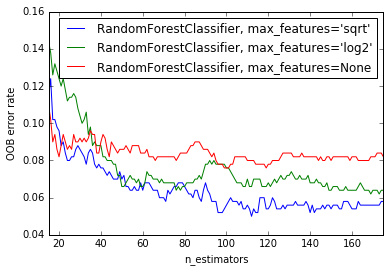

In [3]:
# 估計內部使用多少個 estimators, 一個estimators就是一棵樹, 會把oob error降到最低, 這裡是不同於使用GridSearchCV的參數調校的暴力偵測法

import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

RANDOM_STATE = 123

# Generate a binary classification dataset.
X, y = make_classification(n_samples=500, n_features=25,
                           n_clusters_per_class=1, n_informative=15,
                           random_state=RANDOM_STATE)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestClassifier, max_features='sqrt'",
        RandomForestClassifier(warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features='log2'",
        RandomForestClassifier(warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RandomForestClassifier, max_features=None",
        RandomForestClassifier(warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 15
max_estimators = 175

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1):
        clf.set_params(n_estimators=i)
        clf.fit(X, y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()